In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    classification_report
)


file_path = r"C:\Users\UltraSmart\OneDrive\Desktop\Python\Employee-Attrition.csv"
df = pd.read_csv(file_path)

print("Dataset shape:", df.shape)
df.info()

Dataset shape: (1470, 35)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14

In [83]:
# =========================
# FEATURE SELECTION / CLEAN DATA
# =========================

# Các cột chắc chắn không mang thông tin dự đoán
drop_cols = [
    "EmployeeCount",      # luôn = 1
    "StandardHours",      # luôn = 80
    "Over18",             # luôn = 'Y'
    "EmployeeNumber"      # ID định danh
]

df_clean = df.drop(columns=drop_cols)

# Loại bớt các thuộc tính lương ít ý nghĩa
salary_cols = [
    "DailyRate",
    "HourlyRate",
    "MonthlyRate"
]
df_clean = df_clean.drop(columns=salary_cols)

# Các cột thâm niên trùng thông tin
experience_cols = [
    "YearsInCurrentRole",
    "YearsSinceLastPromotion",
    "YearsWithCurrManager"
]
df_clean = df_clean.drop(columns=experience_cols)

print("Shape sau khi làm sạch:", df_clean.shape)

# =========================
# CHECK IMBALANCE (RẤT QUAN TRỌNG)
# =========================
print("\nPhân bố nhãn Attrition:")
print(df_clean["Attrition"].value_counts())
print(df_clean["Attrition"].value_counts(normalize=True))


Shape sau khi làm sạch: (1470, 25)

Phân bố nhãn Attrition:
Attrition
No     1233
Yes     237
Name: count, dtype: int64
Attrition
No     0.838776
Yes    0.161224
Name: proportion, dtype: float64


In [99]:
print("Số thuộc tính ban đầu (không tính nhãn):", df.shape[1] - 1)
print("Số thuộc tính sau khi làm sạch (không tính nhãn):", df_clean.shape[1] - 1)

print("\nThông tin các thuộc tính sau khi làm sạch:")
df_clean.info()


Số thuộc tính ban đầu (không tính nhãn): 34
Số thuộc tính sau khi làm sạch (không tính nhãn): 24

Thông tin các thuộc tính sau khi làm sạch:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   Department                1470 non-null   object
 4   DistanceFromHome          1470 non-null   int64 
 5   Education                 1470 non-null   int64 
 6   EducationField            1470 non-null   object
 7   EnvironmentSatisfaction   1470 non-null   int64 
 8   Gender                    1470 non-null   object
 9   JobInvolvement            1470 non-null   int64 
 10  JobLevel                  1470 non-null   int64 
 11  JobRole                   1470 non-null   obj

In [85]:
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [86]:
# =========================
# ENCODE CATEGORICAL FEATURES (SỬA)
# =========================

df_encoded = df_clean.copy()

label_encoders = {}

for col in df_encoded.select_dtypes(include="object").columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le

# =========================
# TÁCH X, y
# =========================
X = df_encoded.drop("Attrition", axis=1)
y = df_encoded["Attrition"]

# =========================
# TRAIN / TEST SPLIT (GIỮ stratify)
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)


Train shape: (1176, 24)
Test shape : (294, 24)


In [87]:
# ===== SCALE CHO KNN =====
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ===== KNN  =====
knn = KNeighborsClassifier(
    n_neighbors=15,
    weights="distance"
)
knn.fit(X_train_scaled, y_train)

knn_probs = knn.predict_proba(X_test_scaled)[:, 1]
knn_pred = (knn_probs >= 0.35).astype(int)

# ===== RANDOM FOREST =====
rf = RandomForestClassifier(
    n_estimators=600,
    max_depth=10,
    min_samples_leaf=8,
    class_weight="balanced",
    random_state=42
)
rf.fit(X_train, y_train)

rf_probs = rf.predict_proba(X_test)[:, 1]

# 🔥 THRESHOLD SỬA Ở ĐÂY
rf_pred = (rf_probs >= 0.55).astype(int)


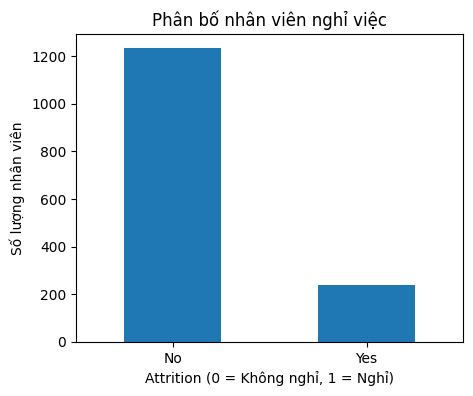

In [88]:
attrition_counts = df_clean["Attrition"].value_counts()

plt.figure(figsize=(5,4))
attrition_counts.plot(kind="bar")
plt.title("Phân bố nhân viên nghỉ việc")
plt.ylabel("Số lượng nhân viên")
plt.xlabel("Attrition (0 = Không nghỉ, 1 = Nghỉ)")
plt.xticks(rotation=0)
plt.show()


<Figure size 600x400 with 0 Axes>

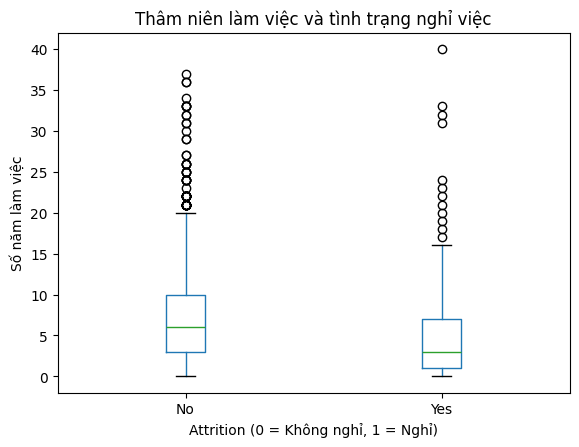

In [89]:
plt.figure(figsize=(6,4))
df_clean.boxplot(
    column="YearsAtCompany",
    by="Attrition",
    grid=False
)
plt.title("Thâm niên làm việc và tình trạng nghỉ việc")
plt.suptitle("")
plt.xlabel("Attrition (0 = Không nghỉ, 1 = Nghỉ)")
plt.ylabel("Số năm làm việc")
plt.show()


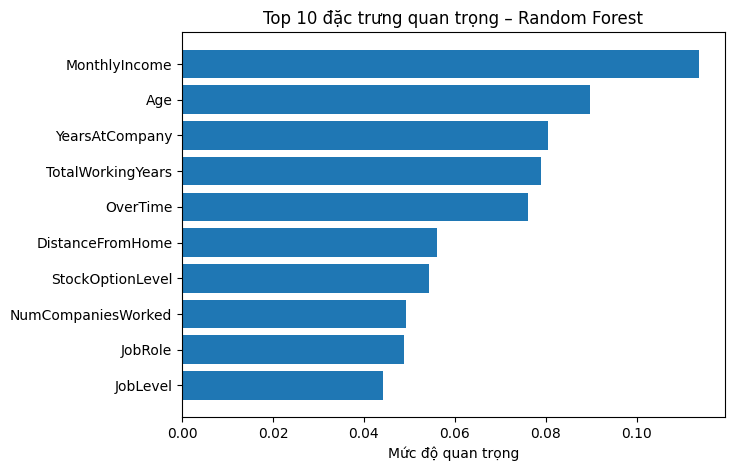

In [90]:
importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]

plt.figure(figsize=(7,5))
plt.barh(X.columns[indices], importances[indices])
plt.title("Top 10 đặc trưng quan trọng – Random Forest")
plt.xlabel("Mức độ quan trọng")
plt.show()


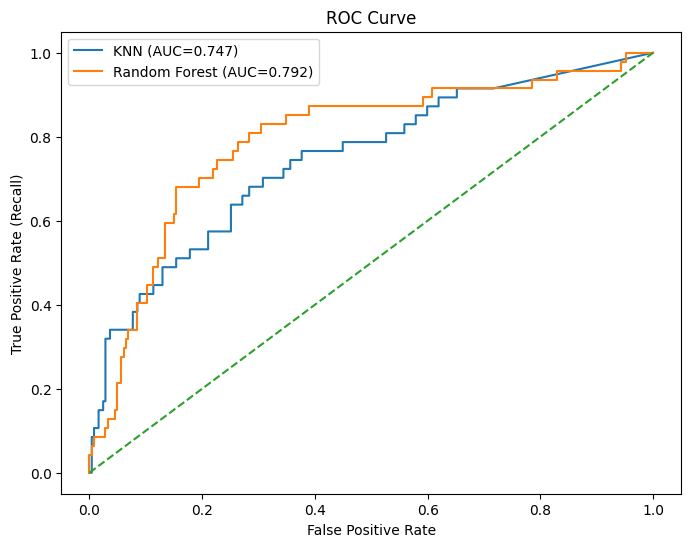

In [101]:
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)

knn_auc = roc_auc_score(y_test, knn_probs)
rf_auc = roc_auc_score(y_test, rf_probs)

plt.figure(figsize=(8,6))
plt.plot(fpr_knn, tpr_knn, label=f"KNN (AUC={knn_auc:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC={rf_auc:.3f})")
plt.plot([0,1], [0,1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.show()



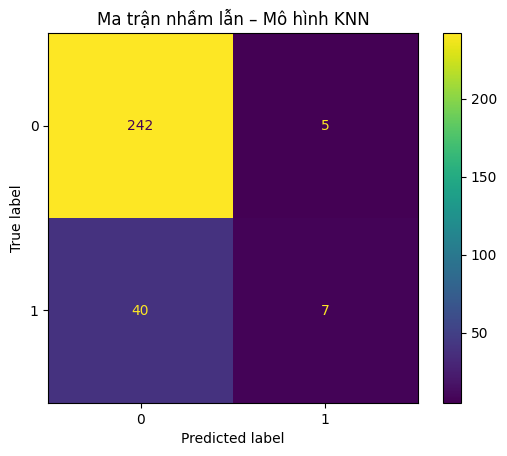

In [92]:
cm_knn = confusion_matrix(y_test, knn_pred)
ConfusionMatrixDisplay(cm_knn).plot()
plt.title("Ma trận nhầm lẫn – Mô hình KNN")
plt.show()



<Figure size 600x600 with 0 Axes>

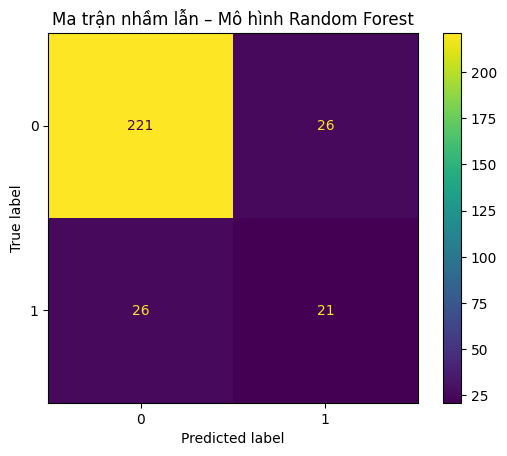

In [93]:
plt.figure(figsize=(6,6))
cm = confusion_matrix(y_test, rf.predict(X_test))
ConfusionMatrixDisplay(cm).plot()
plt.title("Ma trận nhầm lẫn – Mô hình Random Forest")
plt.show()

In [94]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Metrics
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

Accuracy: 0.8401360544217688
Precision: 0.5
Recall: 0.10638297872340426
F1 Score: 0.17543859649122806
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91       247
           1       0.50      0.11      0.18        47

    accuracy                           0.84       294
   macro avg       0.68      0.54      0.54       294
weighted avg       0.80      0.84      0.79       294



In [95]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train) 

y_pred_knn = knn.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred_knn))
print('Precision:', precision_score(y_test, y_pred_knn))
print('Recall:', recall_score(y_test, y_pred_knn))
print('F1 Score:', f1_score(y_test, y_pred_knn))
print('Classification Report:\n', classification_report(y_test, y_pred_knn))

Accuracy: 0.8027210884353742
Precision: 0.21052631578947367
Recall: 0.0851063829787234
F1 Score: 0.12121212121212122
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89       247
           1       0.21      0.09      0.12        47

    accuracy                           0.80       294
   macro avg       0.53      0.51      0.51       294
weighted avg       0.74      0.80      0.77       294



In [100]:
rf_results = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1-score": f1_score(y_test, y_pred),
}

knn_results = {
    "Accuracy": accuracy_score(y_test, y_pred_knn),
    "Precision": precision_score(y_test, y_pred_knn),
    "Recall": recall_score(y_test, y_pred_knn),
    "F1-score": f1_score(y_test, y_pred_knn),
}

df_eval = pd.DataFrame([rf_results, knn_results],
                       index=["Random Forest", "KNN"])

print(df_eval)

               Accuracy  Precision    Recall  F1-score
Random Forest  0.840136   0.500000  0.106383  0.175439
KNN            0.802721   0.210526  0.085106  0.121212
